# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [99]:
import pandas as pd

project = 'NEIL'

#path = 'D:\\Data\\df_STA_%s_2020_12_14.csv' % project
path = 'D:\\Data\\df_STA_%s_2021_01_05.csv' % project

df_sta = pd.read_csv(path)
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude
0,N01,999,1,Left,10.0,0,0.019782
1,N01,999,1,Left,10.0,1,0.015173
2,N01,999,1,Left,10.0,2,0.020359
3,N01,999,1,Left,10.0,3,0.019855
4,N01,999,1,Left,10.0,4,0.018697


#### For this analysis, we will only keep the right side EMG for SPARC and left side EMG for Neilsen (for now)

In [100]:
if 'NEIL' in path: 
    df_sta = df_sta[df_sta["Side"] == 'Left']
else:
    df_sta = df_sta[df_sta["Side"] == 'Right']

In [101]:
print(df_sta.Animal.unique())
print(df_sta.Day_Postop.unique())
print(df_sta.Day_Stim.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['N01' 'N04' 'N05' 'N09' 'N10' 'N11' 'N13' 'N14' 'N15' 'N16' 'N17' 'N19'
 'N20' 'N21' 'N22' 'N23' 'N24' 'N25' 'N26' 'N27' 'N28' 'N29' 'N30' 'N31'
 'N32' 'N33']
[999   2   3   4   5   6   1]
[1 2 3 4 0]
['Left']
[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140.
 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270. 280.
 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410. 420.
 430. 440. 450. 490. 460. 470. 480. 500. 510. 520. 530. 540. 550. 560.
 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690. 700.
 710. 720. 730. 740. 750. 760. 770. 780. 790. 800. 810. 820. 830. 840.
 850. 860. 870. 880. 890. 900. 910.  15.  25.  35.  45.  55.  65.  75.
  85.  95. 105. 115. 125. 135. 145. 155. 165. 175. 185. 195. 205. 215.
 225. 235. 245. 255. 265. 275. 285. 295. 305. 315. 325. 335. 345. 355.
 365. 375. 385. 395. 405. 415. 425. 435. 445. 455. 575. 735. 685.]


In [102]:
df_sta.groupby(['Animal'])['Stim_Amplitude'].unique()

Animal
N01    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N04    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N05    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N09    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N10    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N11    [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80....
N13    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N14    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N15    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N16    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N17    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N19    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N20    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N21    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N22    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N23    [100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0]
N24    [100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160...
N25    [100.0, 110.0, 12

In [103]:
# def custom_round(x, base=10):
#     return int(base * round(float(x)/base))
# df_sta['Stim_Amplitude'] = df_sta['Stim_Amplitude'].apply(lambda x: custom_round(x))

# df_sta.groupby(['Animal'])['Stim_Amplitude'].unique()

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day
There is a lot of data here, so we will subset. Only plot waveforms of stimulation amplitudes divisible by 50 on odd numbered days. We also need to remove the stimulus artifact.

In [104]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta['Time'] = df_sta['Time']*1000
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
0,N01,999,1,Left,10.0,0,0.019782,0.0
1,N01,999,1,Left,10.0,1,0.015173,0.2
2,N01,999,1,Left,10.0,2,0.020359,0.4
3,N01,999,1,Left,10.0,3,0.019855,0.6
4,N01,999,1,Left,10.0,4,0.018697,0.8


In [105]:
df_sta_sub = df_sta.copy()
df_sta_sub = df_sta_sub[(df_sta_sub["Stim_Amplitude"] % 50) == 0] # keep only stimulus amplitudes divisible by 50
"Unique stimulation amplitudes after subsetting are %s uA." % (df_sta_sub.Stim_Amplitude.unique())

'Unique stimulation amplitudes after subsetting are [ 50. 100. 150. 200. 250. 300. 350. 400. 450. 500. 550. 600. 650. 700.\n 750. 800. 850. 900.] uA.'

In [106]:
late_animals = ['N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33']

df_sta.loc[df_sta['Animal'].isin(late_animals)]['Day_Stim']

991200     0
991201     0
991202     0
991203     0
991204     0
          ..
1613395    1
1613396    1
1613397    1
1613398    1
1613399    1
Name: Day_Stim, Length: 316200, dtype: int64

###### The plot below is the raw STA data before any processing

In [107]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1)
# plt.figure(figsize=(20,12))

# g = sns.FacetGrid(df_sta_sub, col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# #plt.savefig('C:\\Users\\Ian\\Downloads\\saving-a-seaborn-plot-as-pdf-file.pdf')


In [108]:
# remove the stimulus artifact
df_sta_noart = df_sta.copy()
df_sta_noart = df_sta_noart[df_sta_noart['Sample'] >= 11]

df_sta_sub_noart = df_sta_sub.copy()
df_sta_sub_noart = df_sta_sub_noart[df_sta_sub_noart['Sample'] >= 11]


#### This was for rescaling the data, but we don't think we will be using this
# # scale STA values to be within the range [0,1]
# from sklearn.preprocessing import minmax_scale

# STA_Scaled = df_sta.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
# df_sta_norm = df_sta.copy()
# df_sta_norm['STA_Scaled'] = df_sta_norm.index.map(STA_Scaled)
# df_sta_norm = df_sta_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

# STA_Scaled_sub = df_sta_sub.groupby(['Animal', 'Side'])['STA_Amplitude'].transform(lambda x: minmax_scale(x.astype(float)))
# df_sta_sub_norm = df_sta_sub.copy()
# df_sta_sub_norm['STA_Scaled'] = df_sta_sub_norm.index.map(STA_Scaled_sub)
# df_sta_sub_norm = df_sta_sub_norm.drop(['STA_Amplitude'], axis=1).reset_index(drop=True)

###### The plot below shows the normalized STAs with stimulus artifact removed

In [109]:
# g = sns.FacetGrid(df_sta_sub_noart, col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# # plt.savefig('C:\\Users\\Ian\\Downloads\\STA_plots_norm_no_artifact.pdf')

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [110]:
#### KEEP THIS. MAY BIN IN FUTURE
# bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
# labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
# #labels = [1, 2, 3, 4, 5]

# df_bin = df_sta_sub_norm.copy()
# df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
# df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Scaled'])
# df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
# df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
# df_bin.head()

In [111]:
df_noisefloor = df_sta_noart.copy()
df_noisefloor = df_noisefloor[(df_noisefloor['Time'] > 20.0)]
df_noisefloor.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
101,N01,999,1,Left,10.0,101,0.026517,20.2
102,N01,999,1,Left,10.0,102,0.020794,20.4
103,N01,999,1,Left,10.0,103,0.022700,20.6
104,N01,999,1,Left,10.0,104,0.028331,20.8
105,N01,999,1,Left,10.0,105,0.031767,21.0


In [112]:
df_auc = df_sta_noart.copy()
df_auc = df_auc[(df_auc['Time'] > 2.0) & (df_auc['Time'] < 10.2)]
df_auc.tail()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time
1613246,N33,3,1,Left,600.0,46,0.016179,9.2
1613247,N33,3,1,Left,600.0,47,0.015948,9.4
1613248,N33,3,1,Left,600.0,48,0.017304,9.6
1613249,N33,3,1,Left,600.0,49,0.014320,9.8
1613250,N33,3,1,Left,600.0,50,0.010725,10.0


In [113]:
import numpy as np
# define animal groups
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# add animal group information to the dataframe
conditions = [
    (df_auc['Animal'].isin(injstim) ),
    (df_auc['Animal'].isin(noinjstim) ),
    (df_auc['Animal'].isin(injnostim) ),
    (df_auc['Animal'].isin(noinjnostim) )]
choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
df_auc['Group'] = np.select(conditions, choices)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Sample,STA_Amplitude,Time,Group
11,N01,999,1,Left,10.0,11,0.026453,2.2,No Injury and Stimulation
12,N01,999,1,Left,10.0,12,0.027991,2.4,No Injury and Stimulation
13,N01,999,1,Left,10.0,13,0.027984,2.6,No Injury and Stimulation
14,N01,999,1,Left,10.0,14,0.026587,2.8,No Injury and Stimulation
15,N01,999,1,Left,10.0,15,0.027326,3.0,No Injury and Stimulation


In [114]:
df_noisefloor = df_noisefloor.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
df_noisefloor['STA_Amplitude'] = df_noisefloor['STA_Amplitude'] * 7.8 # 7.8 because the length of the STA is 7.8 ms
df_noisefloor = df_noisefloor.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
df_noisefloor.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Noise_Floor
0,N01,999,1,Left,10.0,0.210894
1,N01,999,1,Left,20.0,0.174942
2,N01,999,1,Left,30.0,0.166652
3,N01,999,1,Left,40.0,0.153945
4,N01,999,1,Left,50.0,0.249201


In [115]:
from scipy import integrate

df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Group,STA_AUC
0,N01,999,1,Left,10.0,No Injury and Stimulation,1.040341
1,N01,999,1,Left,20.0,No Injury and Stimulation,1.053330
2,N01,999,1,Left,30.0,No Injury and Stimulation,1.025544
3,N01,999,1,Left,40.0,No Injury and Stimulation,1.375108
4,N01,999,1,Left,50.0,No Injury and Stimulation,1.515141


In [116]:
# percent change from noise floor to auc for each day

df_day_pchange = df_auc.copy()
df_day_pchange["STA_Noise_Floor"] = df_noisefloor["STA_Noise_Floor"]
df_day_pchange['STA_Percent_Noise_Floor'] = ((df_day_pchange['STA_AUC'].sub(df_day_pchange["STA_Noise_Floor"])).div(df_day_pchange["STA_Noise_Floor"])).mul(100)
df_day_pchange.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,Group,STA_AUC,STA_Noise_Floor,STA_Percent_Noise_Floor
0,N01,999,1,Left,10.0,No Injury and Stimulation,1.040341,0.210894,393.301469
1,N01,999,1,Left,20.0,No Injury and Stimulation,1.053330,0.174942,502.100974
2,N01,999,1,Left,30.0,No Injury and Stimulation,1.025544,0.166652,515.380948
3,N01,999,1,Left,40.0,No Injury and Stimulation,1.375108,0.153945,793.246078
4,N01,999,1,Left,50.0,No Injury and Stimulation,1.515141,0.249201,508.000257


In [258]:
# do anova here
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_anova = df_day_pchange.copy()
df_anova = df_anova[df_anova['Day_Stim'] > 0]

two_way = ols('STA_Percent_Noise_Floor~Group+Day_Stim', data=df_anova).fit()
aov2 = sm.stats.anova_lm(two_way, type=2)
print(aov2)

              df        sum_sq       mean_sq          F        PR(>F)
Group        3.0  8.192113e+08  2.730704e+08  55.313955  5.708630e-35
Day_Stim     1.0  2.057819e+08  2.057819e+08  41.683787  1.212376e-10
Residual  3697.0  1.825112e+10  4.936737e+06        NaN           NaN


In [247]:
# df_anova = df_day_pchange.copy()
# df_anova = df_anova[df_anova[]]
df_mean_sem = df_day_pchange.groupby(['Group', 'Day_Stim'])['STA_Percent_Noise_Floor'].agg(['mean','sem']).reset_index()
df_mean_sem.rename(columns={'mean':'Mean Percent Change AUC from Noise Floor', 'Day_Stim':'Days of Stimulation'}, inplace=True)
df_mean_sem.head(20)

,Group,Days of Stimulation,Mean Percent Change AUC from Noise Floor,sem
0,Injury and No Stimulation,1,1272.619667,218.850040
1,Injury and No Stimulation,2,988.527555,125.942770
2,Injury and No Stimulation,3,1064.876738,158.520419
3,Injury and No Stimulation,4,931.894343,77.737091
4,Injury and Stimulation,0,1037.099013,68.112366
5,Injury and Stimulation,1,1200.109872,45.013608
6,Injury and Stimulation,2,1341.427258,60.265478
7,Injury and Stimulation,3,2236.694729,193.338979
8,Injury and Stimulation,4,2047.375817,148.009859
9,No Injury and No Stimulation,1,596.718581,17.576633


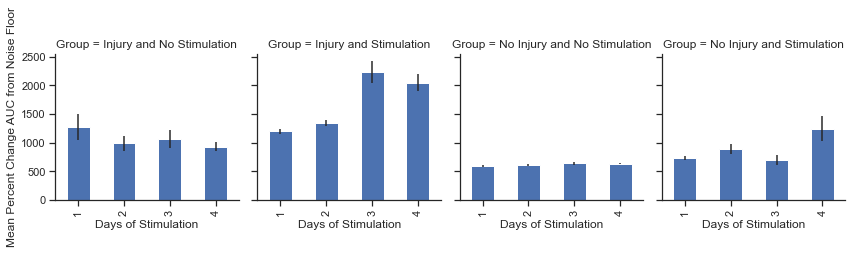

In [252]:
# g=sns.FacetGrid(df_mean_sem[df_mean_sem['Day_Stim'] > 0], col='Group')
# g= g.map(sns.scatterplot, 'Day_Stim', 'mean')


def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)

g=sns.FacetGrid(df_mean_sem[df_mean_sem['Days of Stimulation'] > 0], col='Group')
g.map_dataframe(errplot, "Days of Stimulation", "Mean Percent Change AUC from Noise Floor", "sem")

C:\Users\Ian\anaconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Ian\anaconda3\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


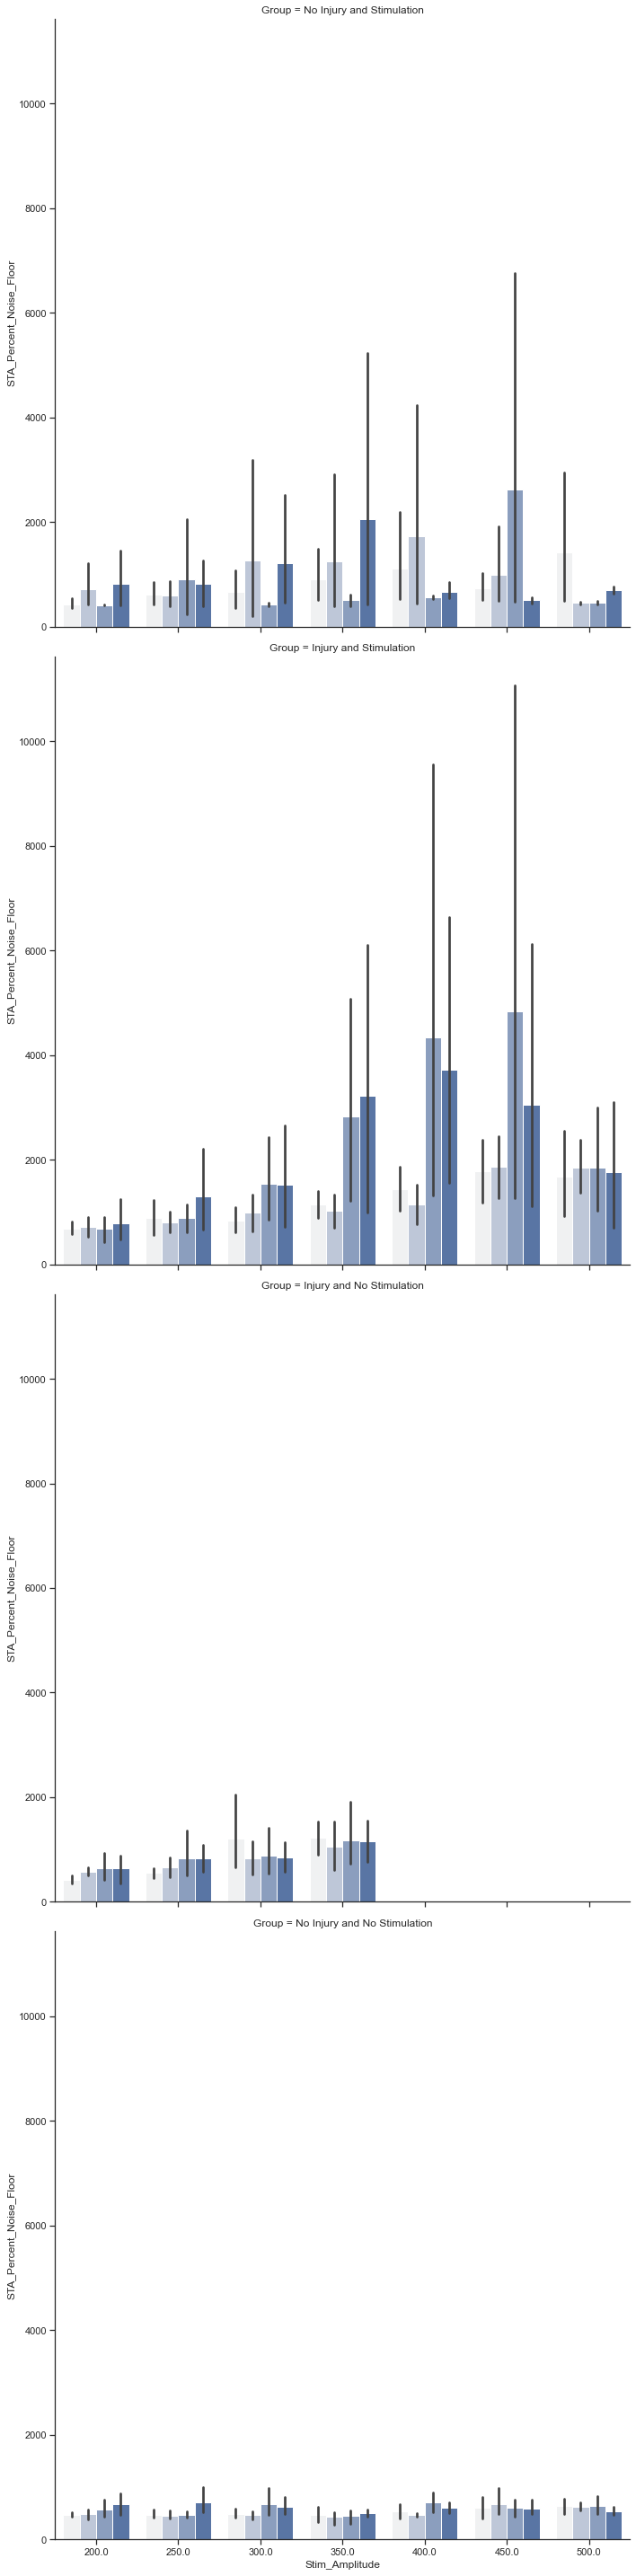

In [215]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500]

# sns.set(rc={'figure.figsize':(80,40)})
# sns.set(font_scale=2)
sns.set_style("ticks")
g = sns.FacetGrid(df_day_pchange[(df_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_day_pchange['Day_Stim'] > 0)],
                  row="Group",
                  height=10,
                  aspect=1,
                  palette=sns.color_palette('coolwarm', n_colors=5))
g = g.map(sns.barplot,
          "Stim_Amplitude",
          "STA_Percent_Noise_Floor",
          'Day_Stim')

fig = g.fig
fig.savefig('D:\\fig.png') 

# sns.barplot(x="Stim_Amplitude",
#             y="STA_Percent_Noise_Floor",
#             hue='Day_Stim',
#             data=df_day_pchange[(df_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_day_pchange['Day_Stim'] > 0)])

# ax = sns.boxplot(x='Stim_Amplitude',
#                  y='STA_Percent_Noise_Floor',
#                  hue='Group',
#                  data=df_day_pchange[(df_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_day_pchange['Day_Stim'] == 4)])
# ax.legend(loc="upper left",
#           title='Stimulation Amplitude (uA)',
#           title_fontsize=16,
#           fontsize=15)


In [153]:
df_mean_day_pchange = df_day_pchange.copy()
df_mean_day_pchange = df_mean_day_pchange.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['STA_Percent_Noise_Floor'].agg('mean').reset_index()
df_mean_day_pchange = df_mean_day_pchange.rename(columns={'STA_Percent_Noise_Floor':'Mean_STA_Percent_Noise_Floor'})
df_mean_day_pchange.head()

,Day_Stim,Stim_Amplitude,Group,Mean_STA_Percent_Noise_Floor
0,0,100.0,Injury and Stimulation,433.090906
1,0,100.0,No Injury and Stimulation,524.234853
2,0,110.0,Injury and Stimulation,451.604815
3,0,110.0,No Injury and Stimulation,458.609339
4,0,120.0,Injury and Stimulation,373.730598


In [157]:
df_med_day_pchange = df_day_pchange.copy()
df_med_day_pchange = df_med_day_pchange.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['STA_Percent_Noise_Floor'].median().reset_index()
df_med_day_pchange = df_med_day_pchange.rename(columns={'STA_Percent_Noise_Floor':'Med_STA_Percent_Noise_Floor'})
df_med_day_pchange.head()

,Day_Stim,Stim_Amplitude,Group,Med_STA_Percent_Noise_Floor
0,0,100.0,Injury and Stimulation,439.430374
1,0,100.0,No Injury and Stimulation,548.278447
2,0,110.0,Injury and Stimulation,473.669747
3,0,110.0,No Injury and Stimulation,469.678582
4,0,120.0,Injury and Stimulation,345.842106


Text(0.5, 0.98, 'Mean')

<Figure size 1440x1440 with 0 Axes>

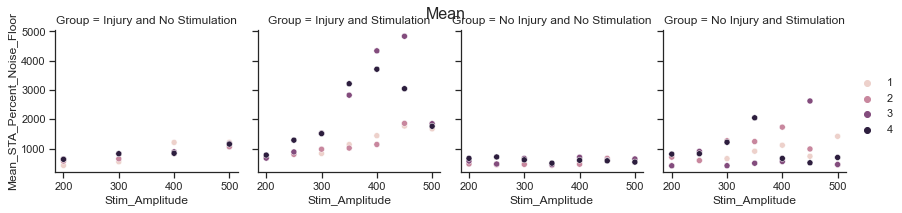

In [173]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500]

plt.figure(figsize=(20,20))
# sns.set(font_scale=2)
sns.set_style("ticks")
g = sns.FacetGrid(df_mean_day_pchange[(df_mean_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_mean_day_pchange['Day_Stim']>0)], col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "Mean_STA_Percent_Noise_Floor", 'Day_Stim').add_legend())
g.fig.suptitle('Mean', fontsize=16)



# ax = sns.boxplot(x='Stim_Amplitude', y='STA_Percent_Noise_Floor', hue='Group', data=df_day_pchange[(df_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_day_pchange['Day_Stim'] == 4)])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize=16, fontsize=15)


Text(0.5, 0.98, 'Median')

<Figure size 1440x864 with 0 Axes>

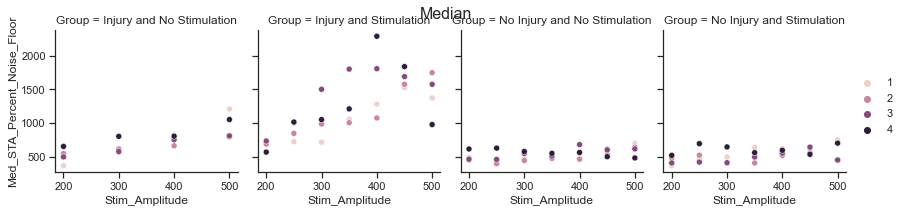

In [160]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500]

plt.figure(figsize=(20,20))
# sns.set(font_scale=2)
sns.set_style("ticks")
g = sns.FacetGrid(df_med_day_pchange[(df_med_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_med_day_pchange['Day_Stim']>0)], col="Group")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "Med_STA_Percent_Noise_Floor", 'Day_Stim').add_legend())
g.fig.suptitle('Median', fontsize=16)



# ax = sns.boxplot(x='Stim_Amplitude', y='STA_Percent_Noise_Floor', hue='Group', data=df_day_pchange[(df_day_pchange['Stim_Amplitude'].isin(stim_amp_list)) & (df_day_pchange['Day_Stim'] == 4)])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize=16, fontsize=15)


In [16]:
# add STA_AUC_Baseline to df_auc
df_auc["STA_Noise_Floor"] = df_noisefloor["STA_Noise_Floor"]
df_auc["STA_AUC_Difference"] = df_auc["STA_AUC"].sub(df_noisefloor["STA_Noise_Floor"])
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_AUC,STA_AUC_Baseline,STA_AUC_Difference
0,N01,999,1,Left,10.0,1.040341,0.210894,0.829447
1,N01,999,1,Left,20.0,1.053330,0.174942,0.878388
2,N01,999,1,Left,30.0,1.025544,0.166652,0.858892
3,N01,999,1,Left,40.0,1.375108,0.153945,1.221163
4,N01,999,1,Left,50.0,1.515141,0.249201,1.265940


In [17]:
import numpy as np
# define animal groups
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# add animal group information to the dataframe
conditions = [
    (df_auc['Animal'].isin(injstim) ),
    (df_auc['Animal'].isin(noinjstim) ),
    (df_auc['Animal'].isin(injnostim) ),
    (df_auc['Animal'].isin(noinjnostim) )]
choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
df_auc['Group'] = np.select(conditions, choices)
df_auc.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_AUC,STA_AUC_Baseline,STA_AUC_Difference,Group
0,N01,999,1,Left,10.0,1.040341,0.210894,0.829447,No Injury and Stimulation
1,N01,999,1,Left,20.0,1.053330,0.174942,0.878388,No Injury and Stimulation
2,N01,999,1,Left,30.0,1.025544,0.166652,0.858892,No Injury and Stimulation
3,N01,999,1,Left,40.0,1.375108,0.153945,1.221163,No Injury and Stimulation
4,N01,999,1,Left,50.0,1.515141,0.249201,1.265940,No Injury and Stimulation


In [18]:
df_pchange = df_auc.copy()
df_pchange = df_pchange.pivot_table(index=['Animal', 'Stim_Amplitude', 'Group'], 
                    columns='Day_Stim', 
                    values='STA_AUC').reset_index()
df_pchange.head()

Day_Stim,Animal,Stim_Amplitude,Group,0,1,2,3,4
0,N01,10.0,No Injury and Stimulation,NaN,1.040341,1.062622,0.849176,1.035510
1,N01,20.0,No Injury and Stimulation,NaN,1.053330,1.402699,NaN,1.196373
2,N01,30.0,No Injury and Stimulation,NaN,1.025544,1.121569,NaN,1.474290
3,N01,40.0,No Injury and Stimulation,NaN,1.375108,1.222323,NaN,1.347887
4,N01,50.0,No Injury and Stimulation,NaN,1.515141,1.044353,1.233956,1.296905


In [42]:
df_pchange["Percent Change AUC Day 1 to Day 4"] = ((df_pchange[4].sub(df_pchange[1])).div(df_pchange[1])).mul(100)
df_pchange["Percent Change AUC Day 1 to Day 3"] = ((df_pchange[3].sub(df_pchange[1])).div(df_pchange[1])).mul(100)
df_pchange["Percent Change AUC Day 1 to Day 2"] = ((df_pchange[2].sub(df_pchange[1])).div(df_pchange[1])).mul(100)

df_pchange.rename(columns = {'Stim_Amplitude':'Stimulation Amplitude'}, inplace = True) 


In [58]:
df_pchange.loc[df_pchange['Animal'] == 'N14']

Day_Stim,Animal,Stimulation Amplitude,Group,0,1,2,3,4,Percent Change AUC Day 1 to Day 4,Percent Change AUC Day 1 to Day 3,Percent Change AUC Day 1 to Day 2
513,N14,100.0,Injury and No Stimulation,NaN,30.131708,21.341164,42.654271,51.161959,69.794419,41.559419,-29.173732
514,N14,200.0,Injury and No Stimulation,NaN,54.020990,52.121857,56.719279,66.615688,23.314453,4.994891,-3.515545
515,N14,300.0,Injury and No Stimulation,NaN,88.168269,78.031306,77.479021,102.057068,15.752604,-12.123690,-11.497292
516,N14,400.0,Injury and No Stimulation,NaN,106.683159,99.369968,108.280207,110.567701,3.641195,1.497001,-6.855056
517,N14,500.0,Injury and No Stimulation,NaN,115.266604,107.614139,110.591827,115.600945,0.290058,-4.055621,-6.638927
518,N14,600.0,Injury and No Stimulation,NaN,113.043515,108.792877,114.579402,117.911723,4.306491,1.358669,-3.760178
519,N14,700.0,Injury and No Stimulation,NaN,124.306460,113.674905,124.984769,116.424675,-6.340608,0.545675,-8.552697


In [21]:
# df_plot = df_pchange.groupby(['Stimulation Amplitude', 'Group'])['Percent Change AUC Day 1 to Day 4'].agg('mean').reset_index()
# df_plot.head()

In [22]:
# df_inj_stim = df_pchange.copy()
# df_inj_stim = df_inj_stim[df_inj_stim['Group'] == "Injury and Stimulation"]
# df_inj_stim.head()

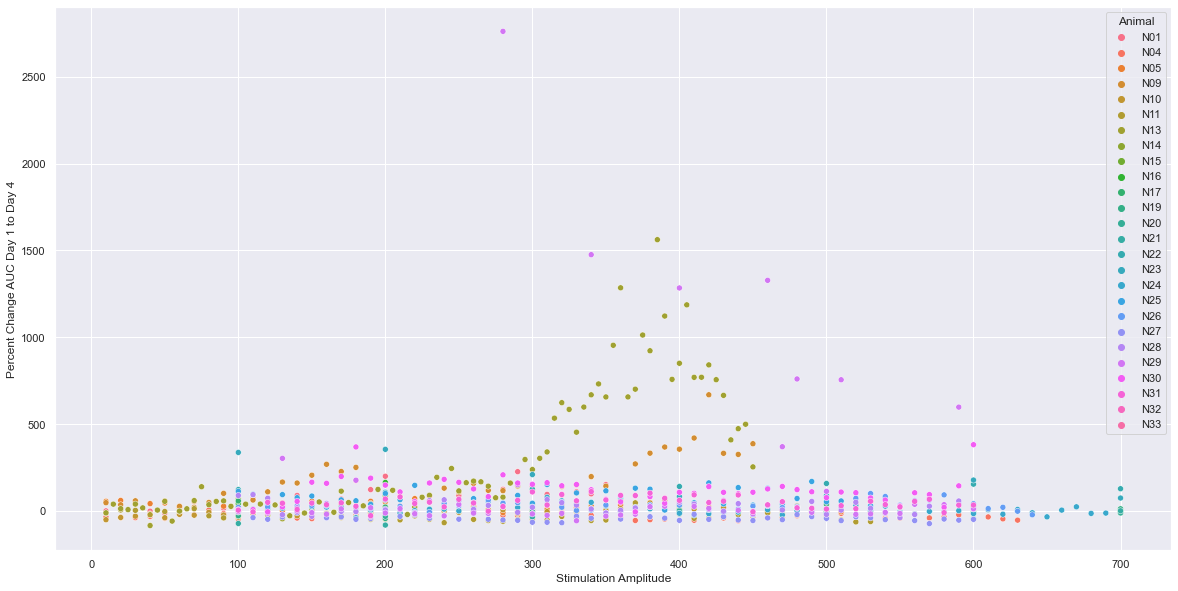

In [44]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1)

ax = sns.scatterplot(x='Stimulation Amplitude', y='Percent Change AUC Day 1 to Day 4', hue='Animal', data=df_pchange)
#ax.set_ylabel('Mean Percent Change STA AUC Day 1 to Day 4')
#plt.savefig('C:\\Users\\iangm\\Downloads\\PLOT.pdf')

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

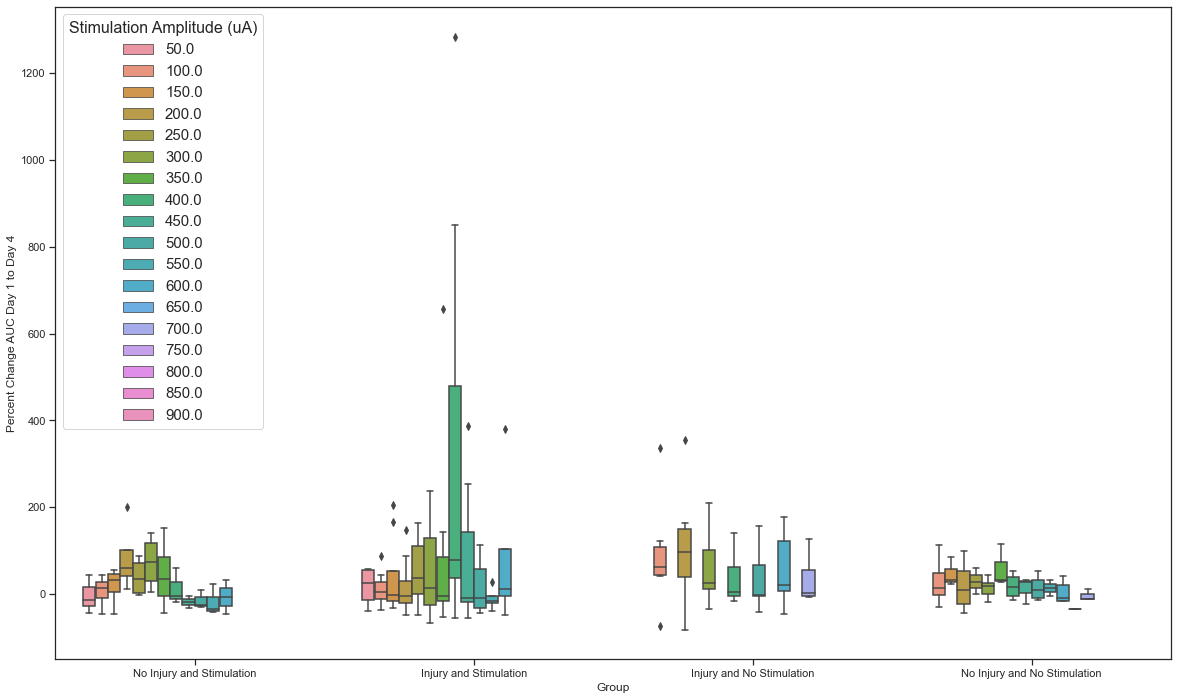

In [65]:
stim_amp_list = [200, 250, 300, 350, 400, 450, 500]

plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
sns.set_style("ticks")
ax = sns.boxplot(x='Group', y='Percent Change AUC Day 1 to Day 4', hue='Stimulation Amplitude', data=df_pchange[df_pchange['Stimulation Amplitude'] % 50 == 0])
ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize=16, fontsize=15)


# CODE BELOW THIS NEEDS TO BE INTEGRATED TO CODE ABOVE

###### Below is a plot showing the data we will be working with. Data are normalized and are cut off at 13 ms after the stimulus. Also, only stimulation amplitudes divisible by 50 are in this dataframe.

In [25]:
# g = sns.FacetGrid(df_bin, col='Day', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Scaled')
# g.set_axis_labels('12 ms duration', 'Ampltiude (V)')
# g.add_legend()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [26]:
# from scipy import integrate

# df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
# df_auc = df_auc.dropna()
# df_auc.head()

### Rough work below

In [27]:
# import numpy as np

# # add animal group information to the dataframe
# conditions = [
#     (df_auc['Animal'] == 'S01') | (df_auc['Animal'] == 'S02'),
#     (df_auc['Animal'] == 'S03') | (df_auc['Animal'] == 'S04'),
#     (df_auc['Animal'] == 'S05') | (df_auc['Animal'] == 'S06')]
# choices = ['Group A', 'Group B', 'Group C']
# df_auc['Group'] = np.select(conditions, choices)
# df_auc.head()

In [28]:
# # function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [29]:
# ### changed function above to take df arg

# df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
#                     columns='Day', 
#                     values='STA_AUC').reset_index()

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
# df_auc_pchange.head()

In [30]:
# df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
# df_auc_pchange.head()

In [31]:
# df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

In [32]:
# # all the bar plots
# sns.set(font_scale=1.5)
# g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
# g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

In [33]:
# day_range = 'Day 4 to Day 18'

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip